# 데이터 전처리 진행

## 데이터 불러오기

In [111]:
!pip install boruta
!pip install mlforecast
!pip install xgboost

In [112]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/bigcontest")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/bigcontest'

In [113]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import time

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from prophet import Prophet

from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.python.keras.layers import Input, Dense, InputLayer, Dropout, GRU, ConvLSTM2D, Flatten

from mlforecast import MLForecast
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

from window_ops.rolling import rolling_mean, rolling_max, rolling_min

In [114]:
# 각 컬럼의 의미 확인용으로 출력
info = pd.read_excel('2023빅콘테스트_빅데이터플랫폼_지정주제(스마트팜)_데이터정의서.xlsx')

In [115]:
# 데이터 불러오기
df = pd.read_csv("STRAWBERRY_FRUIT_SETTING_ENV_20221209.csv")
df.head()

,ZONE_NM,STRG_DT,FRST_TREE_CNT,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,66,2022-01-01 0:00,5.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,2022-01-01 0:10,5.0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,66,2022-01-01 0:20,5.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,66,2022-01-01 0:30,5.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,66,2022-01-01 0:40,5.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## 누락된 데이터 보간

In [116]:
# 2022-06-07 16:40과 17:00 사이에 16:50 추가하기
row_1 = pd.DataFrame({'ZONE_NM': [66], 'STRG_DT': ['2022-06-07 16:50']})
row_1

,ZONE_NM,STRG_DT
0,66,2022-06-07 16:50


In [117]:
row_2 = df.iloc[22708:22710,2:].mean()
row_2 = pd.DataFrame(row_2).T
row_2

,FRST_TREE_CNT,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,CLR_OPRT_YN_1,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,0.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
row_new = pd.concat([row_1, row_2], axis=1)
row_new

,ZONE_NM,STRG_DT,FRST_TREE_CNT,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,66,2022-06-07 16:50,0.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
df = pd.concat([df.iloc[:22709], row_new, df.iloc[22709:]], ignore_index = True)
df

,ZONE_NM,STRG_DT,FRST_TREE_CNT,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,66,2022-01-01 0:00,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,2022-01-01 0:10,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66,2022-01-01 0:20,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66,2022-01-01 0:30,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,66,2022-01-01 0:40,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26059,66,2022-06-30 23:10,0.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26060,66,2022-06-30 23:20,0.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26061,66,2022-06-30 23:30,0.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26062,66,2022-06-30 23:40,0.5,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 정규화 진행

In [120]:
X = df.drop(['FRST_TREE_CNT'], axis=1)
y = df[['FRST_TREE_CNT']]

In [121]:
# 정규화 진행

# 'STRT_DT' 열을 제외한 데이터 추출
X_without_date = X.drop('STRG_DT', axis=1)

# Min-Max 스케일러 초기화 및 스케일링 적용
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_without_date)

# 스케일링된 데이터를 데이터프레임으로 변환
X_train_scaled_df = pd.DataFrame(X_scaled, columns=X_without_date.columns)

# 'STRT_DT' 열을 포함한 데이터프레임과 스케일링된 데이터프레임을 병합
X_scaled = pd.concat([X[['STRG_DT']], X_train_scaled_df], axis=1)

## train-test split

In [122]:
X.shape

(26064, 102)

In [123]:
X_train = X_scaled[:20850]
y_train = y[:20850]

X_test = X_scaled[20850:]
y_test = y[20850:]

# X_test 데이터프레임의 인덱스를 0부터 시작하도록 재설정
X_test.reset_index(drop=True, inplace=True)

In [124]:
X_train

,STRG_DT,ZONE_NM,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,2022-01-01 0:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-01-01 0:10,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-01 0:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-01 0:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-01 0:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,2022-05-25 18:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20846,2022-05-25 18:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20847,2022-05-25 18:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20848,2022-05-25 18:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [125]:
X_test

,STRG_DT,ZONE_NM,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,2022-05-25 19:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-25 19:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-05-25 19:20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-05-25 19:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-05-25 19:40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,2022-06-30 23:10,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5210,2022-06-30 23:20,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5211,2022-06-30 23:30,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5212,2022-06-30 23:40,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 일정한 값 유지하는 상수 컬럼 constant_columns 제거

In [126]:
# constant_columns 제거
constant_columns = []

for column in X_train.columns:
    if X_train[column].nunique() == 1:
        constant_columns.append(column)

X_train = X_train.drop(columns=constant_columns)
print('상수 컬럼으로 제거되는 컬럼 수:', len(constant_columns))
print('제거하는 컬럼:', constant_columns)

상수 컬럼으로 제거되는 컬럼 수: 58
제거하는 컬럼: ['ZONE_NM', 'RTTN_PUMP_OPRT_YN_4', 'RTTN_PUMP_OPRT_YN_3', 'CLR_OPRT_YN_5', 'CLR_OPRT_YN_4', 'CLR_OPRT_YN_3', 'CLR_OPRT_YN_2', 'CLR_OPRT_YN_1', 'CLR_OPMD_5', 'CLR_OPMD_4', 'CLR_OPMD_3', 'CLR_OPMD_2', 'CLR_OPMD_1', 'SUB_MHRLS_OPRT_YN_4', 'SUB_MHRLS_OPMD_1', 'FLFN_OPMD', 'INNER_SRQT', 'RTRVL_TPRT_4', 'INNER_ACCMLT_QOFLG', 'RTRVL_TPRT_3', 'SOIL_TPRT', 'RTRVL_TPRT_2', 'SOIL_HMDT', 'RTRVL_TPRT_1', 'SPL_TPRT_4', 'SKLT_OPMD_2_RIGHT', 'SKLT_OPMD_1_RIGHT', 'HTNG_TPRT_5', 'SKLT_OPMD_1_LEFT', 'SKLT_OPMD_2_LEFT', 'TRWVLV_OPMD_2', 'HRZNT_SCRN_OPMD_2', 'HRZNT_SCRN_OPMD_1', 'HTNG_TPRT_4', 'HTNG_TPRT_3', 'HTNG_TPRT_2', 'VNTILAT_TPRT_2', 'BL_OPRT_YN', 'SPL_TPRT_3', 'INNER_TPRT_3', 'INNER_TPRT_4', 'AVE_INNER_TPRT_3_4', 'INNER_HMDT_5', 'INNER_TPRT_5', 'AVE_INNER_HMDT_3_4', 'INNER_HMDT_4', 'INNER_HMDT_3', 'SUB_MHRLS_OPMD_3', 'SUB_MHRLS_OPMD_2', 'FMGEQ_OPMD', 'INNER_HMDT_9', 'INNER_HMDT_8', 'INNER_HMDT_7', 'INNER_HMDT_6', 'INNER_TPRT_9', 'INNER_TPRT_8', 'INNER_TPRT_7', 'INNER_

In [127]:
X_train.shape

(20850, 44)

In [128]:
# 범주형 변수 확인
categorical_columns = []  # 범주형 열을 저장할 리스트
numeric_columns = []      # 수치형 열을 저장할 리스트

for column in X_train.columns:
    if X_train[column].nunique() == 2:
        categorical_columns.append(column)
    else:
        numeric_columns.append(column)
print("범주형 열 (이진 변수 포함):", categorical_columns)
print("수치형 열:", numeric_columns)

print(len(categorical_columns))
print(len(numeric_columns))

범주형 열 (이진 변수 포함): ['RTTN_PUMP_OPRT_YN_2', 'RTTN_PUMP_OPRT_YN_1', 'DYTM_NIGHT_CD', 'SPRYN_DEVICE', 'SUB_MHRLS_OPRT_YN_1', 'FLFN_OPRT_YN', 'PRCPT_YN', 'CBDX_GNRT_OPMD', 'TRWVLV_OPMD_1', 'CBDX_GNRT_OPRT_YN', 'SUB_MHRLS_OPRT_YN_3', 'SUB_MHRLS_OPRT_YN_2', 'FMGEQ_OPRT_YN']
수치형 열: ['STRG_DT', 'PFBS_NTRO_CBDX_CTRN', 'EXTN_TPRT', 'DWP_TPRT', 'WNDRC', 'ABSLT_HMDT', 'WDSP', 'STRTN_WATER', 'EXTN_SRQT', 'WATER_LACK_VL', 'EXTN_ACCMLT_QOFLG', 'SPL_TPRT_1', 'HTNG_TPRT_1', 'VNTILAT_TPRT_5', 'VNTILAT_TPRT_4', 'VNTILAT_TPRT_3', 'TRWVLV_OPDR_RATE_2', 'TRWVLV_OPDR_RATE_1', 'HRZNT_SCRN_OPDR_RATE_2', 'HRZNT_SCRN_OPDR_RATE_1', 'VNTILAT_TPRT_1', 'SPL_TPRT_2', 'INNER_TPRT_1', 'INNER_TPRT_2', 'AVE_INNER_TPRT_1_2', 'INNER_HMDT_1', 'INNER_HMDT_2', 'AVE_INNER_HMDT_1_2', 'CBDX_STNG_VL', 'SKLT_OPDR_RATE_1_RIGHT', 'SKLT_OPDR_RATE_1_LEFT']
13
31


In [129]:
X_train['STRG_DT'] = pd.to_datetime(X_train['STRG_DT'])  # 날짜 형식으로 변환

# 날짜에서 월만 뽑아서 컬럼 추가
X_train['MONTH'] = X_train['STRG_DT'].dt.month

## boruta 사용

In [130]:
# boruta는 datetime 컬럼은 처리하지 못하므로 제거
X_train.drop(columns=['STRG_DT'], inplace=True)

In [ ]:
y_train_pd = pd.DataFrame(y_train)
y_train2 = y_train_pd.values.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestRegressor(max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, max_iter = 30)
# find all relevant features - 5 features should be selected
feat_selector.fit(np.array(X_train), y_train2)

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	44
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	21
Tentative: 	7
Rejected: 	16
Iteration: 	9 / 30
Confirmed: 	21
Tentative: 	7
Rejected: 	16
Iteration: 	10 / 30
Confirmed: 	21
Tentative: 	7
Rejected: 	16
Iteration: 	11 / 30
Confirmed: 	21
Tentative: 	7
Rejected: 	16
Iteration: 	12 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	20
Iteration: 	13 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	20
Iteration: 	14 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	20
Iteration: 	15 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	20
Iteration: 	16 / 30
Confirmed: 	21
Tentative: 	3
Rejected: 	20
Iteratio

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=135,
                                         random_state=RandomState(MT19937) at 0x7FD7C0B13B40),
         max_iter=30, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FD7C0B13B40, verbose=2)

In [ ]:
# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X_train.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X_train.columns[i], " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Doesn't pass the test:  RTTN_PUMP_OPRT_YN_2  - Ranking:  11
Doesn't pass the test:  RTTN_PUMP_OPRT_YN_1  - Ranking:  20
Doesn't pass the test:  DYTM_NIGHT_CD  - Ranking:  10
Passes the test:  PFBS_NTRO_CBDX_CTRN  - Ranking:  1
Passes the test:  EXTN_TPRT  - Ranking:  1
Passes the test:  DWP_TPRT  - Ranking:  1
Passes the test:  WNDRC  - Ranking:  1
Doesn't pass the test:  SPRYN_DEVICE  - Ranking:  15
Doesn't pass the test:  SUB_MHRLS_OPRT_YN_1  - Ranking:  20
Doesn't pass the test:  FLFN_OPRT_YN  - Ranking:  15
Passes the test:  ABSLT_HMDT  - Ranking:  1
Passes the test:  WDSP  - Ranking:  1
Doesn't pass the test:  STRTN_WATER  - Ranking:  4
Doesn't pass the test:  EXTN_SRQT  - Ranking:  2
Passes the test:  WATER_LACK_VL  - Ranking:  1
Passes the test:  EXTN_ACCMLT_QOFLG  - Ranking:  1
Doesn't pass the test:  PRCPT_YN  - Ranking:  6
Passes the test:  SPL_TPRT_1  - Ranking:  1
Doesn't pass the test:  CBDX_GNRT_OPMD  - Ranking:  15
Doesn'

In [ ]:
boruta_column_extracted = X_train.columns[feat_selector.support_]
print(boruta_column_extracted)
print(len(boruta_column_extracted))

Index(['PFBS_NTRO_CBDX_CTRN', 'EXTN_TPRT', 'DWP_TPRT', 'WNDRC', 'ABSLT_HMDT',
       'WDSP', 'WATER_LACK_VL', 'EXTN_ACCMLT_QOFLG', 'SPL_TPRT_1',
       'HTNG_TPRT_1', 'VNTILAT_TPRT_1', 'SPL_TPRT_2', 'INNER_TPRT_2',
       'AVE_INNER_TPRT_1_2', 'INNER_HMDT_1', 'INNER_HMDT_2',
       'AVE_INNER_HMDT_1_2', 'CBDX_STNG_VL', 'SKLT_OPDR_RATE_1_RIGHT',
       'SKLT_OPDR_RATE_1_LEFT', 'MONTH'],
      dtype='object')
21


In [ ]:
boruta_extracted = X_train[boruta_column_extracted]

## 상관관계 0.8 이상인 컬럼 삭제

In [ ]:
# 3. 상관관계가 0.8 이상인 컬럼 쌍을 식별하고 하나의 컬럼을 제거
correlation_matrix = boruta_extracted.corr()

high_correlation_threshold = 0.8
columns_to_remove = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= high_correlation_threshold:
            column_i = correlation_matrix.columns[i]
            column_j = correlation_matrix.columns[j]
            columns_to_remove.add(column_j)

print('상관 관계로 제거되는 컬럼 수:', len(columns_to_remove))
print('제거하는 컬럼:', columns_to_remove)

# 제거할 컬럼을 X_train에서 삭제
boruta_extracted.drop(columns=columns_to_remove, inplace=True)

상관 관계로 제거되는 컬럼 수: 8
제거하는 컬럼: {'EXTN_TPRT', 'ABSLT_HMDT', 'INNER_HMDT_2', 'SKLT_OPDR_RATE_1_RIGHT', 'INNER_TPRT_2', 'INNER_HMDT_1', 'DWP_TPRT', 'WATER_LACK_VL'}


In [ ]:
# boruta로 선별된 변수에서 상관관계 0.8 이상인 컬럼 제거하고 최종적으로 남은 것을 범주형과 연속형으로 분류.
print("<===========범주형 변수==========>")
c1 = 0
for column in boruta_extracted.columns:
  if column in categorical_columns:
    c1 += 1
    for i in range(len(info)):
      if column == info.at[i, 'Unnamed: 1']:
        print(info. at[i, 'Unnamed: 1'] ,"(",info.at[i, 'Unnamed: 2'], ") : ",info.at[i, 'Unnamed: 5'])
print('범주형 변수 개수: ', c1)
c2 = 0
print("\n\n<===========연속형 변수==========>")
for column in boruta_extracted.columns:
  if column not in categorical_columns:
    c2 += 1
    for i in range(len(info)):
      if column == info.at[i, 'Unnamed: 1']:
        print(info. at[i, 'Unnamed: 1'] ,"(",info.at[i, 'Unnamed: 2'], ") : ",info.at[i, 'Unnamed: 5'])
print('연속형 변수 개수: ', c2)

<===========범주형 변수==========>
범주형 변수 개수:  0


<===========연속형 변수==========>
PFBS_NTRO_CBDX_CTRN ( 관측지점실내이산화탄소농도 ) :  온실 내에서 측정된 이산화탄소 농도임
WNDRC ( 풍향 ) :  온실 외부의 풍향을 나타내는 데이터
WDSP ( 풍속 ) :  온실 외부에서 측정된 풍속
EXTN_ACCMLT_QOFLG ( 외부누적광량 ) :  온실 외부에서 측정된 누적된 광량
SPL_TPRT_1 ( 공급온도_1 ) :   온실 내부로 공급되는 온도
HTNG_TPRT_1 ( 난방온도_1 ) :  온실 내에서 측정된 난방 온도
VNTILAT_TPRT_1 ( 배기온도_1 ) :  온실 내 배기 시스템을 통해 배출되는 온도
SPL_TPRT_2 ( 공급온도_2 ) :   온실 내부로 공급되는 온도
AVE_INNER_TPRT_1_2 ( 평균내부온도_1_2 ) :  1, 2번 온도계로 잰 온실 내부의 평균 온도
AVE_INNER_HMDT_1_2 ( 평균내부습도_1_2 ) :  1, 2번 온도계로 잰 온실 내부의 평균 습도
CBDX_STNG_VL ( 이산화탄소설정값 ) :  이산화탄소 발생기가 생성할 이산화탄소의 목표 농도를 설정하는 값
SKLT_OPDR_RATE_1_LEFT ( 천창개도율_1_좌 ) :  온실의 천창의 개도율을 나타냄. 일광과 환기를 조절하는데 사용
연속형 변수 개수:  13


In [ ]:
boruta_extracted.shape

(20850, 13)

In [ ]:
# df_concat을 CSV 파일로 저장
boruta_extracted.to_csv('column15.csv', index=False)

In [131]:
# 데이터 불러오기
boruta_extracted = pd.read_csv("column15.csv")
boruta_extracted

,PFBS_NTRO_CBDX_CTRN,WNDRC,WDSP,EXTN_ACCMLT_QOFLG,SPL_TPRT_1,HTNG_TPRT_1,VNTILAT_TPRT_1,SPL_TPRT_2,AVE_INNER_TPRT_1_2,AVE_INNER_HMDT_1_2,CBDX_STNG_VL,SKLT_OPDR_RATE_1_LEFT,MONTH
0,0.065941,0.539106,0.247619,0.378145,0.425662,0.321429,0.272,0.071429,0.121951,0.883041,0.6875,0.0,1
1,0.067756,0.572626,0.285714,0.378145,0.560081,0.321429,0.260,0.079670,0.128049,0.883041,0.6875,0.0,1
2,0.073200,0.553073,0.285714,0.378145,0.511202,0.321429,0.248,0.085165,0.134146,0.856725,0.6875,0.0,1
3,0.071990,0.594972,0.247619,0.378145,0.486762,0.321429,0.232,0.082418,0.134146,0.874269,0.6875,0.0,1
4,0.072595,0.539106,0.314286,0.378145,0.482688,0.321429,0.220,0.074176,0.126016,0.928363,0.6875,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,0.033878,0.030726,0.171429,0.891116,0.480652,0.000000,0.200,0.585165,0.510163,0.331871,1.0000,0.4,5
20846,0.029643,0.178771,0.104762,0.893475,0.476578,0.000000,0.200,0.678571,0.504065,0.346491,1.0000,0.4,5
20847,0.032063,0.039106,0.171429,0.895833,0.470468,0.000000,0.200,0.692308,0.495935,0.347953,1.0000,0.4,5
20848,0.032668,0.092179,0.171429,0.897799,0.466395,0.000000,0.200,0.689560,0.491870,0.350877,1.0000,0.4,5


# 모델링 진행
# train_data: X_train, y_train

## Prophet

In [132]:
X_train['STRG_DT'] = pd.to_datetime(df['STRG_DT'])  # 날짜 형식으로 변환
X_train_prophet = pd.concat([X_train['STRG_DT'], boruta_extracted], axis = 1)

In [133]:
X_train_prophet.shape

(20850, 14)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay7rjkne/qhry12lr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpay7rjkne/hwtozh60.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11375', 'data', 'file=/tmp/tmpay7rjkne/qhry12lr.json', 'init=/tmp/tmpay7rjkne/hwtozh60.json', 'output', 'file=/tmp/tmpay7rjkne/prophet_modelgug1qplx/prophet_model-20230926041954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                      ds       yhat  yhat_lower  yhat_upper
5209 2022-06-30 23:10:00  14.060940   -6.505961   33.470008
5210 2022-06-30 23:20:00  14.062315   -6.379013   33.729422
5211 2022-06-30 23:30:00  14.063610   -6.522995   33.510226
5212 2022-06-30 23:40:00  14.064845   -6.645021   33.412244
5213 2022-06-30 23:50:00  14.066044   -6.320878   33.418536


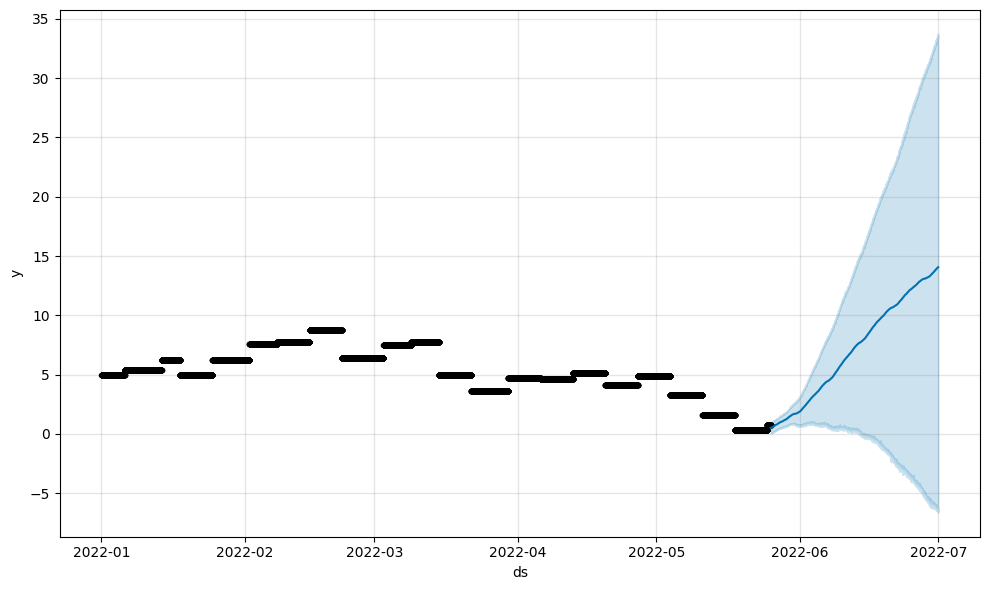

In [134]:
# 'STRG_DT'를 'ds'로 열 이름 변경
X_train_prophet.rename(columns={'STRG_DT': 'ds'}, inplace=True)

# Prophet 모델에 사용할 데이터프레임 생성 (X_train과 y_train 병합)
prophet_data = X_train_prophet.copy()
prophet_data['y'] = y_train

model = Prophet()

model.add_seasonality(name='hourly', period=144, fourier_order=3)

model.fit(prophet_data)

# 예측할 시간 범위 설정
start_date = '2022-05-25 19:00'
end_date = '2022-06-30 23:50'

# 시간 범위 내의 10분 간격을 갖는 모든 날짜와 시간 생성
future = pd.date_range(start=start_date, end=end_date, freq='10T')

# 생성된 날짜와 시간을 'ds' 열로 갖는 데이터프레임 생성
future_df = pd.DataFrame({'ds': future})

# 예측 수행
forecast = model.predict(future_df)

# 예측 결과를 확인
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 시각화
fig = model.plot(forecast)

In [135]:
forecast.shape

(5214, 22)

In [136]:
y_test.shape

(5214, 1)

## MLForecast

In [137]:
X_train['STRG_DT'] = pd.to_datetime(df['STRG_DT'])  # 날짜 형식으로 변환
X_train_MLF = pd.concat([X_train['STRG_DT'], boruta_extracted], axis = 1)

In [138]:
X_train_MLF.head()

,STRG_DT,PFBS_NTRO_CBDX_CTRN,WNDRC,WDSP,EXTN_ACCMLT_QOFLG,SPL_TPRT_1,HTNG_TPRT_1,VNTILAT_TPRT_1,SPL_TPRT_2,AVE_INNER_TPRT_1_2,AVE_INNER_HMDT_1_2,CBDX_STNG_VL,SKLT_OPDR_RATE_1_LEFT,MONTH
0,2022-01-01 00:00:00,0.065941,0.539106,0.247619,0.378145,0.425662,0.321429,0.272,0.071429,0.121951,0.883041,0.6875,0.0,1
1,2022-01-01 00:10:00,0.067756,0.572626,0.285714,0.378145,0.560081,0.321429,0.260,0.079670,0.128049,0.883041,0.6875,0.0,1
2,2022-01-01 00:20:00,0.073200,0.553073,0.285714,0.378145,0.511202,0.321429,0.248,0.085165,0.134146,0.856725,0.6875,0.0,1
3,2022-01-01 00:30:00,0.071990,0.594972,0.247619,0.378145,0.486762,0.321429,0.232,0.082418,0.134146,0.874269,0.6875,0.0,1
4,2022-01-01 00:40:00,0.072595,0.539106,0.314286,0.378145,0.482688,0.321429,0.220,0.074176,0.126016,0.928363,0.6875,0.0,1


In [139]:
X_train_MLF.shape

(20850, 14)

In [140]:
X_train_MLF.drop(columns= 'MONTH', inplace=True)

In [141]:
zone_nm = df["ZONE_NM"].apply(lambda x: str(x))

In [142]:
X_train_MLF['ZONE_NM'] = zone_nm[:20850]

In [143]:
X_train_MLF['y'] = y_train

In [144]:
X_train_MLF.head()

,STRG_DT,PFBS_NTRO_CBDX_CTRN,WNDRC,WDSP,EXTN_ACCMLT_QOFLG,SPL_TPRT_1,HTNG_TPRT_1,VNTILAT_TPRT_1,SPL_TPRT_2,AVE_INNER_TPRT_1_2,AVE_INNER_HMDT_1_2,CBDX_STNG_VL,SKLT_OPDR_RATE_1_LEFT,ZONE_NM,y
0,2022-01-01 00:00:00,0.065941,0.539106,0.247619,0.378145,0.425662,0.321429,0.272,0.071429,0.121951,0.883041,0.6875,0.0,66,5.0
1,2022-01-01 00:10:00,0.067756,0.572626,0.285714,0.378145,0.560081,0.321429,0.260,0.079670,0.128049,0.883041,0.6875,0.0,66,5.0
2,2022-01-01 00:20:00,0.073200,0.553073,0.285714,0.378145,0.511202,0.321429,0.248,0.085165,0.134146,0.856725,0.6875,0.0,66,5.0
3,2022-01-01 00:30:00,0.071990,0.594972,0.247619,0.378145,0.486762,0.321429,0.232,0.082418,0.134146,0.874269,0.6875,0.0,66,5.0
4,2022-01-01 00:40:00,0.072595,0.539106,0.314286,0.378145,0.482688,0.321429,0.220,0.074176,0.126016,0.928363,0.6875,0.0,66,5.0


In [145]:
X_train_MLF.shape

(20850, 15)

In [146]:
models = [make_pipeline(RandomForestRegressor(random_state=0, n_estimators=100)),
          XGBRegressor(random_state=0, n_estimators=100)]


model = MLForecast(models=models,
                   freq='10T',
                   lags=[144,288,432],
                   lag_transforms={
                       144: [(rolling_mean, 144), (rolling_min, 144), (rolling_max, 144)], # aplicado a uma janela W a partir do registro Lag
                   },
                   date_features=['month', 'day', 'hour', 'minute'],
                   num_threads=6)

In [147]:
# fit
model.fit(X_train_MLF, id_col='ZONE_NM', time_col='STRG_DT', target_col='y', static_features=[])

MLForecast(models=[Pipeline, XGBRegressor], freq=<10 * Minutes>, lag_features=['lag144', 'lag288', 'lag432', 'rolling_mean_lag144_window_size144', 'rolling_min_lag144_window_size144', 'rolling_max_lag144_window_size144'], date_features=['month', 'day', 'hour', 'minute'], num_threads=6)

In [148]:
X_test_MLF = X_test

X_test_MLF['STRG_DT'] = pd.to_datetime(X_test['STRG_DT'])

In [149]:
X_test_MLF

,STRG_DT,ZONE_NM,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,2022-05-25 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-25 19:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-05-25 19:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-05-25 19:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-05-25 19:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,2022-06-30 23:10:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5210,2022-06-30 23:20:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5211,2022-06-30 23:30:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5212,2022-06-30 23:40:00,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
X_test_MLF['ZONE_NM'] = zone_nm[20850:].reset_index(drop= True)

In [151]:
X_test_MLF

,STRG_DT,ZONE_NM,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,...,SKLT_OPDR_RATE_1_LEFT,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6
0,2022-05-25 19:00:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-05-25 19:10:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-05-25 19:20:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-05-25 19:30:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-05-25 19:40:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,2022-06-30 23:10:00,66,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5210,2022-06-30 23:20:00,66,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5211,2022-06-30 23:30:00,66,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5212,2022-06-30 23:40:00,66,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
y_MLF = pd.DataFrame(y_test['FRST_TREE_CNT'])
y_MLF.rename(columns = {'FRST_TREE_CNT': 'y'}, inplace = True)
y_MLF = y_MLF.reset_index(drop= True)

In [153]:
y_MLF

,y
0,0.75
1,0.75
2,0.75
3,0.75
4,0.75
...,...
5209,0.50
5210,0.50
5211,0.50
5212,0.50


In [154]:
X_test_MLF = pd.concat([X_test_MLF, y_MLF], axis = 1)

In [155]:
X_test_MLF.head()

,STRG_DT,ZONE_NM,RTTN_PUMP_OPRT_YN_4,RTTN_PUMP_OPRT_YN_3,RTTN_PUMP_OPRT_YN_2,RTTN_PUMP_OPRT_YN_1,CLR_OPRT_YN_5,CLR_OPRT_YN_4,CLR_OPRT_YN_3,CLR_OPRT_YN_2,...,FMGEQ_OPRT_YN,INNER_HMDT_9,INNER_HMDT_8,INNER_HMDT_7,INNER_HMDT_6,INNER_TPRT_9,INNER_TPRT_8,INNER_TPRT_7,INNER_TPRT_6,y
0,2022-05-25 19:00:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
1,2022-05-25 19:10:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
2,2022-05-25 19:20:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
3,2022-05-25 19:30:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75
4,2022-05-25 19:40:00,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.75


In [156]:
X_test_MLF.columns

Index(['STRG_DT', 'ZONE_NM', 'RTTN_PUMP_OPRT_YN_4', 'RTTN_PUMP_OPRT_YN_3',
       'RTTN_PUMP_OPRT_YN_2', 'RTTN_PUMP_OPRT_YN_1', 'CLR_OPRT_YN_5',
       'CLR_OPRT_YN_4', 'CLR_OPRT_YN_3', 'CLR_OPRT_YN_2',
       ...
       'FMGEQ_OPRT_YN', 'INNER_HMDT_9', 'INNER_HMDT_8', 'INNER_HMDT_7',
       'INNER_HMDT_6', 'INNER_TPRT_9', 'INNER_TPRT_8', 'INNER_TPRT_7',
       'INNER_TPRT_6', 'y'],
      dtype='object', length=103)

In [157]:
X_train_MLF.columns

Index(['STRG_DT', 'PFBS_NTRO_CBDX_CTRN', 'WNDRC', 'WDSP', 'EXTN_ACCMLT_QOFLG',
       'SPL_TPRT_1', 'HTNG_TPRT_1', 'VNTILAT_TPRT_1', 'SPL_TPRT_2',
       'AVE_INNER_TPRT_1_2', 'AVE_INNER_HMDT_1_2', 'CBDX_STNG_VL',
       'SKLT_OPDR_RATE_1_LEFT', 'ZONE_NM', 'y'],
      dtype='object')

In [158]:
# predict
p = model.predict(horizon=5214, dynamic_dfs=[X_test_MLF[X_train_MLF.columns]])

In [159]:
p = p.merge(X_test_MLF[['ZONE_NM', 'STRG_DT', 'y']], on=['ZONE_NM', 'STRG_DT'], how='left')

## LSTM

In [160]:
X_train = boruta_extracted

In [161]:
print(X_train)

       PFBS_NTRO_CBDX_CTRN     WNDRC      WDSP  EXTN_ACCMLT_QOFLG  SPL_TPRT_1  \
0                 0.065941  0.539106  0.247619           0.378145    0.425662   
1                 0.067756  0.572626  0.285714           0.378145    0.560081   
2                 0.073200  0.553073  0.285714           0.378145    0.511202   
3                 0.071990  0.594972  0.247619           0.378145    0.486762   
4                 0.072595  0.539106  0.314286           0.378145    0.482688   
...                    ...       ...       ...                ...         ...   
20845             0.033878  0.030726  0.171429           0.891116    0.480652   
20846             0.029643  0.178771  0.104762           0.893475    0.476578   
20847             0.032063  0.039106  0.171429           0.895833    0.470468   
20848             0.032668  0.092179  0.171429           0.897799    0.466395   
20849             0.030248  0.100559  0.142857           0.898978    0.456212   

       HTNG_TPRT_1  VNTILAT

In [162]:
X_train.shape

(20850, 13)

In [163]:
num_of_columns = X_train.shape[1]

In [164]:
# ndarray로 변환
X_train_lstm = X_train.values
X_test_lstm = X_test.values

print(X_train_lstm.shape)

X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], num_of_columns, 1)

print(X_train_lstm.shape)
print(y_train.shape)

(20850, 13)
(20850, 13, 1)
(20850, 1)


In [165]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(num_of_columns, 1)))
model.add(Dense(1))  # 예측값은 연속형 변수이므로 하나의 뉴런을 가진 출력 레이어 사용
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train_lstm, y_train, epochs=100, batch_size=30, verbose=1)

Epoch 1/100
695/695 [==============================] - 8s 8ms/step - loss: 4.5915
Epoch 2/100
695/695 [==============================] - 4s 6ms/step - loss: 1.7761
Epoch 3/100
695/695 [==============================] - 5s 7ms/step - loss: 1.3672
Epoch 4/100
695/695 [==============================] - 6s 9ms/step - loss: 1.2819
Epoch 5/100
695/695 [==============================] - 5s 8ms/step - loss: 1.2442
Epoch 6/100
695/695 [==============================] - 6s 8ms/step - loss: 1.2332
Epoch 7/100
695/695 [==============================] - 4s 6ms/step - loss: 1.1860
Epoch 8/100
695/695 [==============================] - 4s 6ms/step - loss: 1.1666
Epoch 9/100
695/695 [==============================] - 5s 8ms/step - loss: 1.1415
Epoch 10/100
695/695 [==============================] - 5s 7ms/step - loss: 1.1277
Epoch 11/100
695/695 [==============================] - 4s 6ms/step - loss: 1.1053
Epoch 12/100
695/695 [==============================] - 5s 7ms/step - loss: 1.0634
Epoch 13/100


In [166]:
type(X_train.columns)

pandas.core.indexes.base.Index

In [167]:
X_test['STRG_DT'] = pd.to_datetime(X_test['STRG_DT'])  # 날짜 형식으로 변환

# 날짜에서 월만 뽑아서 컬럼 추가
X_test['MONTH'] = X_test['STRG_DT'].dt.month

# boruta는 datetime 컬럼은 처리하지 못하므로 제거
X_test.drop(columns=['STRG_DT'], inplace=True)

In [168]:
X_train.columns

Index(['PFBS_NTRO_CBDX_CTRN', 'WNDRC', 'WDSP', 'EXTN_ACCMLT_QOFLG',
       'SPL_TPRT_1', 'HTNG_TPRT_1', 'VNTILAT_TPRT_1', 'SPL_TPRT_2',
       'AVE_INNER_TPRT_1_2', 'AVE_INNER_HMDT_1_2', 'CBDX_STNG_VL',
       'SKLT_OPDR_RATE_1_LEFT', 'MONTH'],
      dtype='object')

In [169]:
X_test.columns

Index(['ZONE_NM', 'RTTN_PUMP_OPRT_YN_4', 'RTTN_PUMP_OPRT_YN_3',
       'RTTN_PUMP_OPRT_YN_2', 'RTTN_PUMP_OPRT_YN_1', 'CLR_OPRT_YN_5',
       'CLR_OPRT_YN_4', 'CLR_OPRT_YN_3', 'CLR_OPRT_YN_2', 'CLR_OPRT_YN_1',
       ...
       'FMGEQ_OPRT_YN', 'INNER_HMDT_9', 'INNER_HMDT_8', 'INNER_HMDT_7',
       'INNER_HMDT_6', 'INNER_TPRT_9', 'INNER_TPRT_8', 'INNER_TPRT_7',
       'INNER_TPRT_6', 'MONTH'],
      dtype='object', length=102)

In [170]:
X_test = X_test[X_train.columns]

y_pred_lstm = model.predict(X_test)

print(y_pred_lstm.shape)

163/163 [==============================] - 1s 4ms/step
(5214, 1)


## ConvLSTM

In [171]:
# ndarray로 변환

X_train_conlstm = X_train.values
X_test_conlstm = X_test.values

print(X_train_conlstm.shape)

X_train_conlstm = X_train_conlstm.reshape(X_train_conlstm.shape[0], 1, num_of_columns, 1, 1)
# X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 23, 1)

print(X_train_conlstm.shape)

(20850, 13)
(20850, 1, 13, 1, 1)


In [172]:
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(4), input_shape=(1, num_of_columns, 1, 1), padding='same', return_sequences=False))

# input_shape = (time_steps, rows, columns, channels)
# 시계열 데이터의 경우, channels 1로 고정

model.add(Flatten())
model.add(Dense(1))  # 예측값은 연속형 변수이므로 하나의 뉴런을 가진 출력 레이어 사용

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(X_train_conlstm, y_train, epochs=100, batch_size=64)

Epoch 1/100
326/326 [==============================] - 6s 7ms/step - loss: 24.3945
Epoch 2/100
326/326 [==============================] - 2s 7ms/step - loss: 6.0318
Epoch 3/100
326/326 [==============================] - 2s 7ms/step - loss: 4.4983
Epoch 4/100
326/326 [==============================] - 2s 7ms/step - loss: 4.4264
Epoch 5/100
326/326 [==============================] - 4s 11ms/step - loss: 4.3629
Epoch 6/100
326/326 [==============================] - 3s 8ms/step - loss: 4.3067
Epoch 7/100
326/326 [==============================] - 2s 7ms/step - loss: 4.2678
Epoch 8/100
326/326 [==============================] - 2s 7ms/step - loss: 4.2349
Epoch 9/100
326/326 [==============================] - 2s 7ms/step - loss: 4.2058
Epoch 10/100
326/326 [==============================] - 3s 8ms/step - loss: 4.1743
Epoch 11/100
326/326 [==============================] - 4s 12ms/step - loss: 4.1432
Epoch 12/100
326/326 [==============================] - 2s 7ms/step - loss: 4.1122
Epoch 13/1

In [173]:
X_test = X_test[X_train.columns]
X_test_convlstm = X_test.values

# ndarray로 변환
X_test_convlstm = X_test_convlstm.reshape(X_test_convlstm.shape[0], 1, num_of_columns, 1, 1)
y_pred_convlstm = model.predict(X_test_convlstm)
print(y_pred_convlstm.shape)

163/163 [==============================] - 1s 2ms/step
(5214, 1)


## GRU

In [174]:
y_train

,FRST_TREE_CNT
0,5.00
1,5.00
2,5.00
3,5.00
4,5.00
...,...
20845,0.75
20846,0.75
20847,0.75
20848,0.75


In [175]:
#X_train_GRU = X_train.drop(['STRG_DT'], axis=1)
X_train_GRU = X_train
X_train_GRU = X_train_GRU.values
X_train_GRU

array([[0.06594071, 0.53910615, 0.24761905, ..., 0.6875    , 0.        ,
        1.        ],
       [0.0677556 , 0.5726257 , 0.28571429, ..., 0.6875    , 0.        ,
        1.        ],
       [0.07320024, 0.55307263, 0.28571429, ..., 0.6875    , 0.        ,
        1.        ],
       ...,
       [0.03206292, 0.03910615, 0.17142857, ..., 1.        , 0.4       ,
        5.        ],
       [0.03266788, 0.09217877, 0.17142857, ..., 1.        , 0.4       ,
        5.        ],
       [0.03024803, 0.10055866, 0.14285714, ..., 1.        , 0.4       ,
        5.        ]])

In [176]:
# X_test_GRU = X_test.drop(['STRG_DT'], axis=1)
X_test_GRU = X_test.values
X_test_GRU

array([[0.03266788, 0.06424581, 0.17142857, ..., 1.        , 0.2       ,
        5.        ],
       [0.03206292, 0.08379888, 0.20952381, ..., 1.        , 0.3       ,
        5.        ],
       [0.03145796, 0.06145251, 0.17142857, ..., 1.        , 0.4       ,
        5.        ],
       ...,
       [0.04597701, 0.98324022, 0.        , ..., 0.        , 0.        ,
        6.        ],
       [0.04839685, 0.98603352, 0.        , ..., 0.        , 0.        ,
        6.        ],
       [0.0508167 , 0.98603352, 0.        , ..., 0.        , 0.        ,
        6.        ]])

In [177]:
X_train_GRU = X_train_GRU.reshape(X_train_GRU.shape[0], 13, 1)
# X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 23, 1)

In [179]:
model = Sequential()
model.add(GRU(units=50, activation='relu', input_shape=(13, 1)))
model.add(Dense(1))  # 예측값은 연속형 변수이므로 하나의 뉴런을 가진 출력 레이어 사용
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train_GRU, y_train, epochs=100, batch_size=30, verbose=1)

Epoch 1/100
695/695 [==============================] - 11s 13ms/step - loss: 4.7161
Epoch 2/100
695/695 [==============================] - 10s 14ms/step - loss: 2.0646
Epoch 3/100
695/695 [==============================] - 8s 12ms/step - loss: 1.8756
Epoch 4/100
695/695 [==============================] - 8s 11ms/step - loss: 1.3716
Epoch 5/100
695/695 [==============================] - 14s 20ms/step - loss: 1.2371
Epoch 6/100
695/695 [==============================] - 12s 17ms/step - loss: 1.2372
Epoch 7/100
695/695 [==============================] - 12s 17ms/step - loss: 1.2369
Epoch 8/100
695/695 [==============================] - 7s 10ms/step - loss: 1.2247
Epoch 9/100
695/695 [==============================] - 11s 16ms/step - loss: 1.2191
Epoch 10/100
695/695 [==============================] - 9s 12ms/step - loss: 1.2007
Epoch 11/100
695/695 [==============================] - 7s 10ms/step - loss: 1.2006
Epoch 12/100
695/695 [==============================] - 10s 14ms/step - loss: 1

In [180]:
y_pred_gru = model.predict(X_test_GRU)

163/163 [==============================] - 1s 3ms/step


In [181]:
X_train_GRU.shape

(20850, 13, 1)

In [182]:
X_train

,PFBS_NTRO_CBDX_CTRN,WNDRC,WDSP,EXTN_ACCMLT_QOFLG,SPL_TPRT_1,HTNG_TPRT_1,VNTILAT_TPRT_1,SPL_TPRT_2,AVE_INNER_TPRT_1_2,AVE_INNER_HMDT_1_2,CBDX_STNG_VL,SKLT_OPDR_RATE_1_LEFT,MONTH
0,0.065941,0.539106,0.247619,0.378145,0.425662,0.321429,0.272,0.071429,0.121951,0.883041,0.6875,0.0,1
1,0.067756,0.572626,0.285714,0.378145,0.560081,0.321429,0.260,0.079670,0.128049,0.883041,0.6875,0.0,1
2,0.073200,0.553073,0.285714,0.378145,0.511202,0.321429,0.248,0.085165,0.134146,0.856725,0.6875,0.0,1
3,0.071990,0.594972,0.247619,0.378145,0.486762,0.321429,0.232,0.082418,0.134146,0.874269,0.6875,0.0,1
4,0.072595,0.539106,0.314286,0.378145,0.482688,0.321429,0.220,0.074176,0.126016,0.928363,0.6875,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20845,0.033878,0.030726,0.171429,0.891116,0.480652,0.000000,0.200,0.585165,0.510163,0.331871,1.0000,0.4,5
20846,0.029643,0.178771,0.104762,0.893475,0.476578,0.000000,0.200,0.678571,0.504065,0.346491,1.0000,0.4,5
20847,0.032063,0.039106,0.171429,0.895833,0.470468,0.000000,0.200,0.692308,0.495935,0.347953,1.0000,0.4,5
20848,0.032668,0.092179,0.171429,0.897799,0.466395,0.000000,0.200,0.689560,0.491870,0.350877,1.0000,0.4,5



# 성능 평가

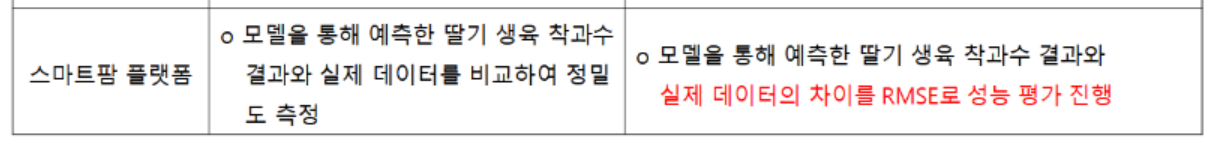

## Prophet

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, forecast['yhat'])

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 7.78978435512619


## MLForecast (Pipeline)

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, p['Pipeline'])

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 1.5674290298655096


## MLForecast (XGBRegressor)

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, p['XGBRegressor'])

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 1.6568494227917852


## LSTM

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, y_pred_lstm)

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 1.0335708113117161


## ConvLSTM

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, y_pred_convlstm)

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 0.6306112666687833


## GRU

In [ ]:
# 예측 결과와 실제 값 간의 평균 제곱 오차(MSE) 계산
mse = mean_squared_error(y_test, y_pred_gru)

# MSE를 RMSE로 변환 (평균 제곱근 오차)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

RMSE: 1.8712029338800085


# 시각화

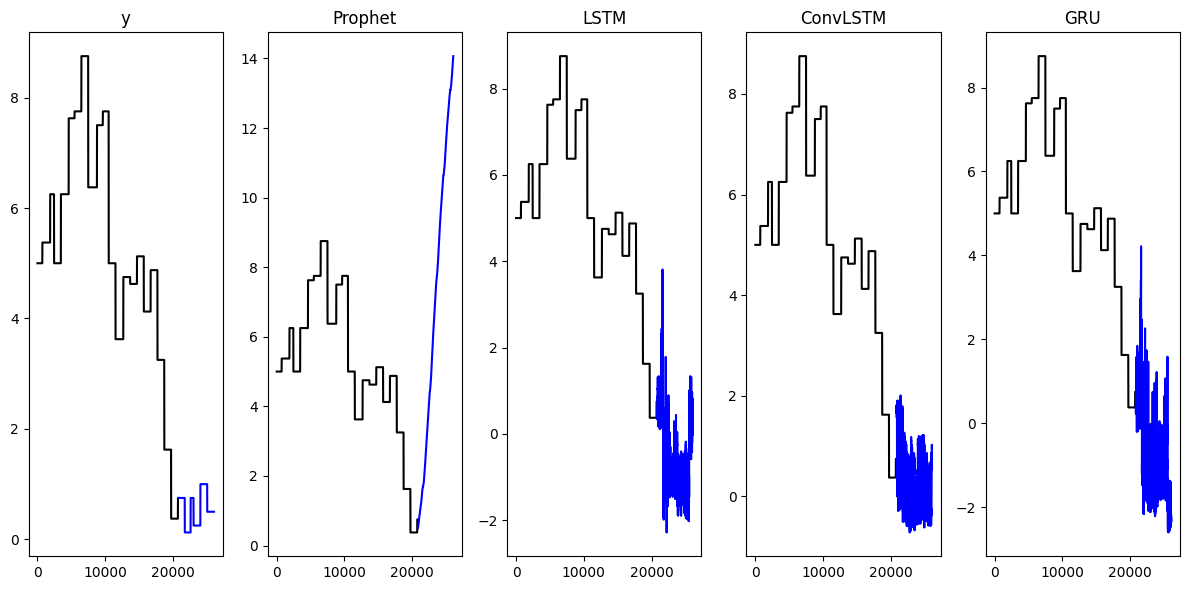

In [ ]:
prophet = forecast['yhat']
lstm = pd.DataFrame(y_pred_lstm)
convlstm = pd.DataFrame(y_pred_convlstm)
gru = pd.DataFrame(y_pred_gru)

prophet.index = np.arange(20850, len(prophet) + 20850)
lstm.index = np.arange(20850, len(lstm) + 20850)
convlstm.index = np.arange(20850, len(convlstm) + 20850)
gru.index = np.arange(20850, len(gru) + 20850)

plt.figure(figsize=(12, 6))

plt.subplot(151)
plt.plot(y[:20850], 'k')
plt.plot(y[20850:], 'b')
plt.title("y")

plt.subplot(152)
plt.plot(y[:20850], 'k')
plt.plot(prophet, 'b')
plt.title("Prophet")

plt.subplot(153)
plt.plot(y[:20850], 'k')
plt.plot(lstm, 'b')
plt.title("LSTM")

plt.subplot(154)
plt.plot(y[:20850], 'k')
plt.plot(convlstm, 'b')
plt.title("ConvLSTM")

plt.subplot(155)
plt.plot(y[:20850], 'k')
plt.plot(gru, 'b')
plt.title("GRU")


plt.tight_layout()
plt.show()

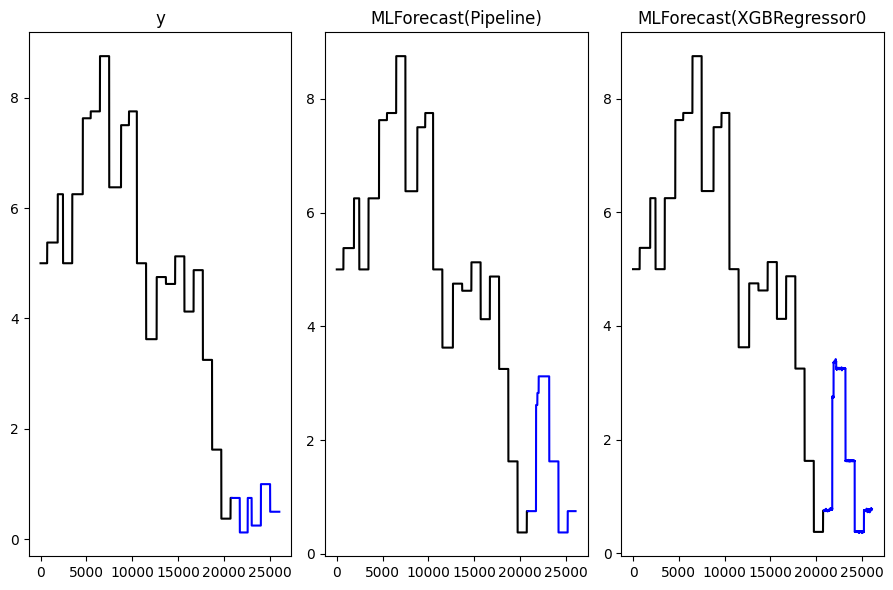

In [ ]:
pipeline = p['Pipeline']
pipeline.index = np.arange(20850, len(pipeline) + 20850)
xgb = p['XGBRegressor']
xgb.index = np.arange(20850, len(xgb) + 20850)

plt.figure(figsize=(12, 6))

plt.subplot(141)
plt.plot(y[:20850], 'k')
plt.plot(y[20850:], 'b')
plt.title("y")

plt.subplot(142)
plt.plot(y[:20850], 'k')
plt.plot(pipeline, 'b')
plt.title("MLForecast(Pipeline)")

plt.subplot(143)
plt.plot(y[:20850], 'k')
plt.plot(xgb, 'b')
plt.title("MLForecast(XGBRegressor0")

plt.tight_layout()
plt.show()